In [6]:
import pandas as pd
import numpy as np
from py_pcha import PCHA

df = pd.read_csv("E:/Opossum_Paper/Figure 3/mouse_triangle_integrated.csv")
df = df.loc[df["method"] == "Stereo-seq"]
X = np.array(df[["X", "Y"]])

XC, S, C, SSE, varexpl = PCHA(X.T, noc=3, delta=0.1)

In [7]:
XC

matrix([[ 11.87301209,  18.06222956, -23.35867567],
        [ 31.10435784, -10.64603097,   1.23764692]])

In [19]:
XC_r = XC[:, [1, 0, 2]]

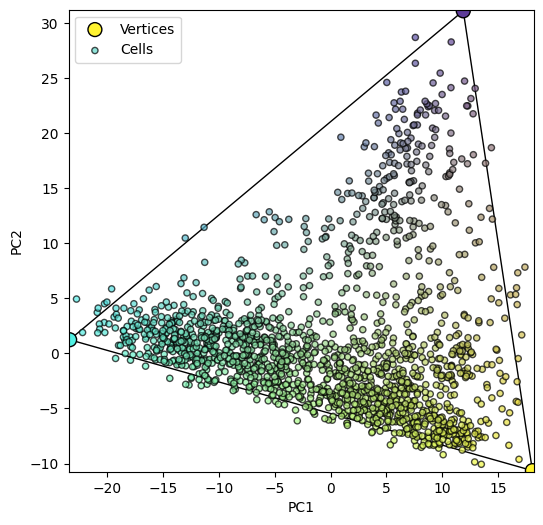

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd
from sklearn.neighbors import kneighbors_graph
import networkx as nx

# Existing data
cells = np.array(X)
vertices = np.array(XC_r.T)
colors = np.array([[1., 0.95294118, 0.18823529], [0.36863, 0.23529, 0.6], [0.31764706, 0.94117647, 0.89019608]]) # Yellow, Purple, Cyan

# Function to compute barycentric coordinates
def barycentric_coords(triangle, points):
    A, B, C = triangle[0], triangle[1], triangle[2]  # Each (2,) - Extract vertices
    v0, v1 = B - A, C - A  # (2,) - Basis vectors of the triangle
    v2 = points - A  # (N, 2) - Vectors from A to each cell
    
    d00 = np.dot(v0, v0)  # Scalar - Dot product of v0 with itself
    d01 = np.dot(v0, v1)  # Scalar - Dot product of v0 with v1
    d11 = np.dot(v1, v1)  # Scalar - Dot product of v1 with itself
    d20 = np.sum(v2 * v0, axis=1)  # (N,) - Dot product of v2 with v0
    d21 = np.sum(v2 * v1, axis=1)  # (N,) - Dot product of v2 with v1
    
    denom = d00 * d11 - d01 * d01  # Scalar - Determinant of the matrix
    v = (d11 * d20 - d01 * d21) / denom  # (N,) - Barycentric coordinate for vertex B
    w = (d00 * d21 - d01 * d20) / denom  # (N,) - Barycentric coordinate for vertex C
    u = 1 - v - w  # (N,) - Barycentric coordinate for vertex A
    
    return np.vstack((u, v, w)).T  # (N, 3) - Barycentric coordinates for all cells

# Ensure correct shape for vertices
if vertices.shape[1] != 2:
    vertices = vertices.T  # Ensure (3,2) shape

bary_coords = barycentric_coords(vertices, cells)
bary_coords = np.clip(bary_coords, 0, 1)
cell_colors = np.clip(np.dot(bary_coords, colors), 0, 1)
cell_names = df["cell"]

rgb_df = pd.DataFrame(cell_colors, columns=["R", "G", "B"], index=cell_names)

# Euclidean distances
euclidean_distances = cdist(cells, vertices, metric='euclidean')
for i, vertex_label in enumerate(['Vertex_B', 'Vertex_C', 'Vertex_A']):
    rgb_df[f'Euclidean_to_{vertex_label}'] = euclidean_distances[:, i]

# Geodesic distances via KNN graph (nearest neighbors = 10, adjustable)
n_neighbors = 5
knn_graph = kneighbors_graph(cells, n_neighbors=n_neighbors, mode='distance', include_self=False)
G = nx.from_scipy_sparse_array(knn_graph, edge_attribute='weight')

# Compute geodesic distances from each vertex to all points
vertex_indices = [np.argmin(np.linalg.norm(cells - vertex, axis=1)) for vertex in vertices]

geodesic_distances = np.zeros((cells.shape[0], len(vertices)))
for idx, vertex_idx in enumerate(vertex_indices):
    lengths = nx.single_source_dijkstra_path_length(G, vertex_idx)
    geodesic_distances[:, idx] = [lengths.get(i, np.inf) for i in range(cells.shape[0])]

# Add geodesic distances to dataframe
for i, vertex_label in enumerate(['Vertex_B', 'Vertex_C', 'Vertex_A']):
    rgb_df[f'Geodesic_to_{vertex_label}'] = geodesic_distances[:, i]

# Save RGB triplets with cell names to CSV
rgb_df.to_csv("E:/Opossum_Paper/Figure 3/mouse_integrated_PC_colors_geodesic.csv")

# Visualization remains the same
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(np.min(vertices[:, 0]) - 0.1, np.max(vertices[:, 0]) + 0.1)
ax.set_ylim(np.min(vertices[:, 1]) - 0.1, np.max(vertices[:, 1]) + 0.1)
ax.triplot(vertices[:, 0], vertices[:, 1], [[0, 1, 2]], color='k', linewidth=1)
ax.scatter(vertices[:, 0], vertices[:, 1], c=colors, edgecolor='black', s=100, label='Vertices')
ax.scatter(cells[:, 0], cells[:, 1], c=cell_colors, s=20, edgecolor='k', alpha=0.7, label='Cells')
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend()
plt.show()

In [24]:
rgb_df

,R,G,B,Euclidean_to_Vertex_B,Euclidean_to_Vertex_C,Euclidean_to_Vertex_A,Geodesic_to_Vertex_B,Geodesic_to_Vertex_C,Geodesic_to_Vertex_A
cell,,,,,,,,,
59317793335536,0.380874,0.846062,0.792790,36.426143,38.043208,8.772902,37.807560,42.273968,8.081345
59154584578296,0.474394,0.919010,0.720579,32.432718,39.970253,10.772579,33.717888,40.685203,11.200276
58978490919059,0.501668,0.785683,0.647514,27.811429,31.121172,18.753760,28.611980,30.516679,19.760090
58935541246083,0.448862,0.887665,0.736449,33.175918,38.667453,10.502119,34.397426,40.271084,10.388378
58420145170637,0.456342,0.540546,0.611944,30.735811,17.012888,30.723806,31.167383,14.806124,36.038047
...,...,...,...,...,...,...,...,...,...
31413390814895,0.442367,0.871757,0.737817,33.175323,37.845757,10.866123,34.755787,39.927853,10.988960
30842160164381,0.570293,0.812482,0.585534,24.032667,31.664529,21.431312,24.179554,30.814472,22.377468
30799210491495,0.394407,0.814004,0.768005,34.876957,35.602246,11.331414,36.563600,39.134440,11.220874
